In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from src.paychex_ml.external_data import get_bls_data
from src.paychex_ml.external_data import get_census_data
from src.paychex_ml.external_data import get_fred_data

# Data

## BLS

In [7]:
seriesid = ["LNS14000000", "CEU0000000001", "CES0000000001"]

In [8]:
df = get_bls_data(seriesid)

Processing:  LNS14000000
Processing:  CEU0000000001
Processing:  CES0000000001


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 20220401 to 20150101
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UnemploymentRate  88 non-null     float64
 1   NFPayrolls_nsa    88 non-null     float64
 2   NFPayrolls_sa     88 non-null     float64
dtypes: float64(3)
memory usage: 2.8+ KB


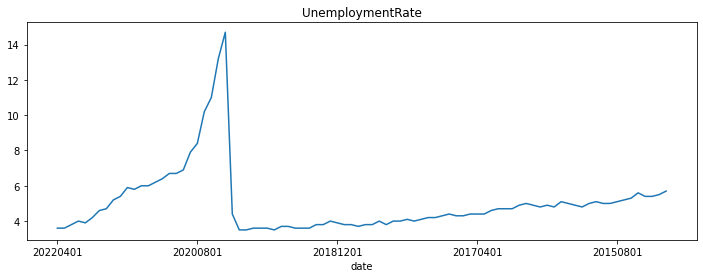

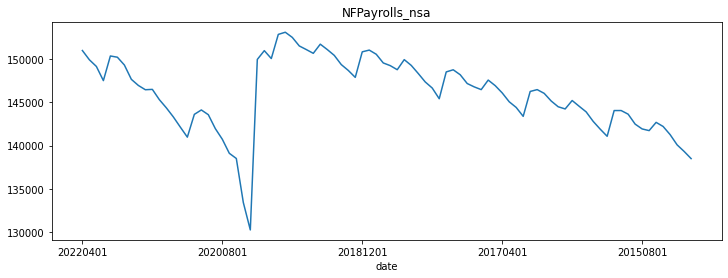

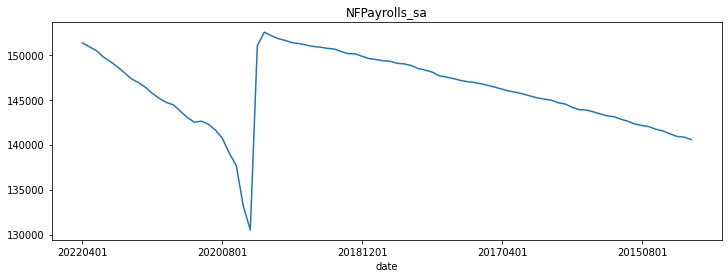

In [10]:
for c in df.columns:
    fig, ax = plt.subplots(figsize=(12,4))
    df[c].plot(ax = ax)
    plt.title(c)

## Census

In [11]:
df = get_census_data()

Reading census data


In [12]:
df

seasonally_adj,BusinessApplications_nsa,BusinessApplications_sa
date,,
20150101,258765,256949
20150201,244207,229473
20150301,249226,229317
20150401,296477,231164
20150501,212198,224660
...,...,...
20211201,372825,418884
20220101,445536,428443
20220201,446342,419130


## FRED

In [13]:
series_dict = {
    'Nation Income & Expenditures': ['GDPC1', 'GDPPOT', 'W875RX1', 'PCEC96', 'PSAVERT', 'FYFR', 'FYONET', 'FYFSD','GFDEBTN'],
    'Pop Employment Labor': ['PAYEMS', 'UNRATE', 'ICSA', 'UEMPMEAN', 'JTSJOL', 'AWHMAN', 'AHETPI', 'OPHNFB', 'POP', 'CLF16OV',
                             'CIVPART'],
    'Prod & Bus Act': ['INDPRO', 'TCU', 'BUSINV', 'RRSFS', 'ALTSALES', 'DGORDER', 'BUSLOANS', 'TOTALSL', 'CP', 'HOUST', 'PERMIT',
                       'UNDCONTSA'],
    'Prices': ['CPIAUCSL', 'PCEPI', 'PCEPILFE', 'GDPDEF', 'PPIFIS', 'WPSFD49207', 'WPSFD4131', 'WPSID62', 'USSTHPI', 'SPCS20RSA',
               'DCOILWTICO', 'GASREGW', 'MHHNGSP'],
    'Money Bank Finance': ['BOGMBASE', 'M1SL', 'M2SL', 'SP500', 'DJIA', 'WILL5000IND', 'VIXCLS', 'STLFSI2', 'BAMLCC0A2AATRIV', 'FF', 'WGS3MO', 'WGS1YR', 'WGS5YR', 'WFII5', 'WGS10YR', 'WFII10', 'WAAA', 'WBAA', 'MORTGAGE15US', 'MORTGAGE30US', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS']

}

In [14]:
df_ext = get_fred_data(series_dict)

Loading category:  Nation Income & Expenditures
Loading series:  GDPC1
Loading series:  GDPPOT
Loading series:  W875RX1
Loading series:  PCEC96
Loading series:  PSAVERT
Loading series:  FYFR
Loading series:  FYONET
Loading series:  FYFSD
Loading series:  GFDEBTN
Loading category:  Pop Employment Labor
Loading series:  PAYEMS
Loading series:  UNRATE
Loading series:  ICSA
Loading series:  UEMPMEAN
Loading series:  JTSJOL
Loading series:  AWHMAN
Loading series:  AHETPI
Loading series:  OPHNFB
Loading series:  POP
Loading series:  CLF16OV
Loading series:  CIVPART
Loading category:  Prod & Bus Act
Loading series:  INDPRO
Loading series:  TCU
Loading series:  BUSINV
Loading series:  RRSFS
Loading series:  ALTSALES
Loading series:  DGORDER
Loading series:  BUSLOANS
Loading series:  TOTALSL
Loading series:  CP
Loading series:  HOUST
Loading series:  PERMIT
Loading series:  UNDCONTSA
Loading category:  Prices
Loading series:  CPIAUCSL
Loading series:  PCEPI
Loading series:  PCEPILFE
Loading ser

In [6]:
df_ext.head()

Nation Income & Expenditures                                          \
                                GDPC1        GDPPOT  W875RX1   PCEC96 PSAVERT   
date                                                                            
20100101                 15456.059000  16173.804340  10490.7  10547.0     5.9   
20100201                 15507.577211  16192.208007  10487.0  10586.5     5.6   
20100301                 15554.109789  16208.830673  10529.1  10637.1     5.6   
20100401                 15605.628000  16227.234340  10638.7  10658.8     6.2   
20100501                 15645.404044  16245.702080  10740.6  10685.3     6.7   

                                                                  \
                  FYFR        FYONET         FYFSD       GFDEBTN   
date                                                               
20100101  2.124281e+06  3.497422e+06 -1.373142e+06  1.277312e+07   
20100201  2.129183e+06  3.492276e+06 -1.363093e+06  1.292078e+07   
20100301  2.133610e+06  3.487627e+06 -1.354017e+06  1.305414e+07   
20100401  2.138512e+06  3.482480e+06 -1.343968e+06  1.320179e+07   
20100501  2.143256e+06  3.477500e+06 -1.334244e+06  1.332042e+07   

         Pop Employment Labor  ... Money Bank Finance                          \
                       PAYEMS  ...              WFII5 WGS10YR  WFII10    WAAA   
date                           ...                                              
20100101             129790.0  ...             0.4380   3.750  1.3940  5.2760   
20100201             129698.0  ...             0.4175   3.695  1.4225  5.3500   
20100301             129879.0  ...             0.5325   3.705  1.4900  5.2575   
20100401             130110.0  ...             0.6360   3.850  1.5160  5.2940   
20100501             130650.0  ...             0.4100   3.420  1.3075  4.9625   

                                                                          
            WBAA MORTGAGE15US MORTGAGE30US   DEXUSEU   DEXCHUS   DEXCAUS  
date                                                                      
20100101  6.2780       4.4350       5.0300  1.426574  6.826916  1.043811  
20100201  6.3475       4.3675       4.9900  1.367995  6.828463  1.057211  
20100301  6.2625       4.3300       4.9675  1.357004  6.826183  1.022900  
20100401  6.2660       4.4180       5.0980  1.341682  6.825550  1.005209  
20100501  6.0500       4.2775       4.8875  1.256315  6.827450  1.040280  

[5 rows x 68 columns]

#### Dictionary

In [7]:
# dictionary = []
# for k in series_dict:
#     print(k)
#     for s in series_dict[k]:
#         url = 'https://api.stlouisfed.org/fred/series?series_id={}&api_key={}&file_type=json'\
#             .format(s,"2f07bf8c1db37581bdb4874f8fa68418")
#         p = requests.get(url)
#         json_response = json.loads(p.text)
#         df = pd.DataFrame(json_response['seriess'])
#         dictionary.append(df)
# pd.concat(dictionary)#.to_excel('DictionaryFRED.xlsx')

# Correlations

In [8]:
from io import BytesIO
from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials
import matplotlib.pyplot as plt

In [9]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [10]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [11]:
# Download file
file = 'table_predictable.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [13]:
items = ['401K Asset fee & BP Revenue',
         '401K Fee Revenue',
         'ASO Allocation',
         'ASO Revenue - Oasis',
         'Benetrac',
         'Cafeteria Plans Revenue',
         'Delivery Revenue',
         'Emerging Products',
         'ESR Revenue',
         'Full Service Unemployment Revenue',
         'Health Benefits',
         'HR Online',
         'HR Solutions (PEO)',
         'Interest on Funds Held for Clients',
         'Other Processing Revenue',
         'Payroll blended products',
         'SurePayroll.',
         'Time & Attendance',
         'Total international',
         'Total Paychex Advance',
         'Total PEO',
         'W-2 Revenue',
         'Workers Comp - Payment Services'
         ]

In [14]:
df_items = df[(df['Scenario']=='Actual')&(df['Item'].isin(items))]\
    .groupby(['Calendar Date', 'Item']).sum()\
    .unstack(level=1)['Value']

In [106]:
df_items

Item,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,ESR Revenue,Emerging Products,Full Service Unemployment Revenue,...,Interest on Funds Held for Clients,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total PEO,Total Paychex Advance,Total international,W-2 Revenue,Workers Comp - Payment Services
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,4261452.0,10621963.0,7255027.55,0.00,1922941.0,1714950.0,7393351.97,47602.0,796063.0,1869396.0,...,3308154.0,4765775.19,99633512.0,3246967.02,4651817.0,12948696.0,0.0,0.0,7031234.09,4858397.0
20140701,4513388.0,10558382.0,9070820.80,0.00,1916579.0,1698495.0,13513741.18,67521.0,986955.0,2341533.0,...,3466375.0,6502729.54,121619696.0,3362473.02,5165885.0,14670286.0,0.0,0.0,7325377.82,5244318.0
20140801,4486436.0,10297495.0,7489159.50,0.00,1944830.0,1829118.0,7286966.62,79771.0,924689.0,1986835.0,...,3434419.0,4215268.17,99472483.0,3286111.93,4856677.0,14606689.0,0.0,0.0,7443620.46,5588578.0
20140901,4355891.0,12719409.0,7011292.24,0.00,1933042.0,1710602.0,7081861.96,105330.0,732444.0,1888067.0,...,3419918.0,4726806.24,94198230.0,3345328.53,5098280.0,14456325.0,0.0,0.0,7414842.11,4968759.0
20141001,4455231.0,13797724.0,9372927.59,0.00,1956820.0,1702224.0,13741077.44,143956.0,1051920.0,2491011.0,...,3472038.0,6514037.07,124353873.0,3402641.78,5188982.0,14544813.0,0.0,0.0,7818212.35,5752070.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,8601656.0,14541668.0,13265382.71,273995.85,1390060.0,1771611.0,22548298.89,3955284.0,4341243.0,3071647.0,...,5034424.0,8645189.69,94834624.0,7062932.96,11004027.0,71734133.0,5542882.0,0.0,80988881.77,5399816.0
20210201,8798633.0,14785257.0,13666646.86,291755.39,1354163.0,1685096.0,6430193.76,11179898.0,3735642.0,3103960.0,...,4984652.0,6625228.73,96978102.0,6757198.28,10433968.0,65858229.0,5572132.0,0.0,28599.77,5392816.0
20210301,9014864.0,15017238.0,16053700.85,253715.04,1404115.0,1667442.0,7657980.44,5180501.0,4687474.0,3648121.0,...,5028113.0,6834861.06,110554131.0,7127288.42,11520879.0,70139857.0,6534835.0,0.0,-43477.46,7384007.0


In [20]:
df_ext.droplevel(0, axis=1).shift(1)

,GDPC1,GDPPOT,W875RX1,PCEC96,PSAVERT,FYFR,FYONET,FYFSD,GFDEBTN,PAYEMS,...,WFII5,WGS10YR,WFII10,WAAA,WBAA,MORTGAGE15US,MORTGAGE30US,DEXUSEU,DEXCHUS,DEXCAUS
date,,,,,,,,,,,,,,,,,,,,,
20100101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100201,15456.059000,16173.804340,10490.7,10547.0,5.9,2.124281e+06,3.497422e+06,-1.373142e+06,1.277312e+07,129790.0,...,0.4380,3.750,1.3940,5.2760,6.2780,4.4350,5.0300,1.426574,6.826916,1.043811
20100301,15507.577211,16192.208007,10487.0,10586.5,5.6,2.129183e+06,3.492276e+06,-1.363093e+06,1.292078e+07,129698.0,...,0.4175,3.695,1.4225,5.3500,6.3475,4.3675,4.9900,1.367995,6.828463,1.057211
20100401,15554.109789,16208.830673,10529.1,10637.1,5.6,2.133610e+06,3.487627e+06,-1.354017e+06,1.305414e+07,129879.0,...,0.5325,3.705,1.4900,5.2575,6.2625,4.3300,4.9675,1.357004,6.826183,1.022900
20100501,15605.628000,16227.234340,10638.7,10658.8,6.2,2.138512e+06,3.482480e+06,-1.343968e+06,1.320179e+07,130110.0,...,0.6360,3.850,1.5160,5.2940,6.2660,4.4180,5.0980,1.341682,6.825550,1.005209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20310601,NaN,23654.885165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20310701,NaN,23688.814835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20310801,NaN,23721.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
def correlation_analysis(item, df_items, df_ext, lag=0, plot=True, figsize=(16,18)):

    # Join tables
    df_join = df_items[item].to_frame().join(df_ext.shift(lag))
    df_join.index = pd.to_datetime(df_join.index)

    # Calculate corelations
    cor = df_join.corr()[item][1:]

    if plot:
        # Fist plot: time series item vs external data
        m = 4
        n = np.ceil((df_join.shape[1]-1)/m).astype(int)
        fig, axs = plt.subplots(n, m, sharex=True, sharey=True, figsize=figsize)
        axsf = axs.flat
        i=0
        for c in df_join.columns[1:]:
            ax1 = axsf[i]
            ax1.plot(df_join.iloc[:,0], color='darkblue', lw=1)
            ax2 = ax1.twinx()
            ax2.plot(df_join[c], color = 'red', ls="--", label=c, lw=1)
            ax2.legend(fontsize='x-small', frameon=False)
            i+=1
        plt.suptitle("{} vs external data timelines".format(item), fontsize=14)
        plt.tight_layout()
        plt.show()

        # Second plot: correlations
        fig, ax = plt.subplots(figsize=(16,4))
        cor.plot.bar(ax=ax, title="Correlations {} vs external data".format(item))
        plt.show()

    return cor

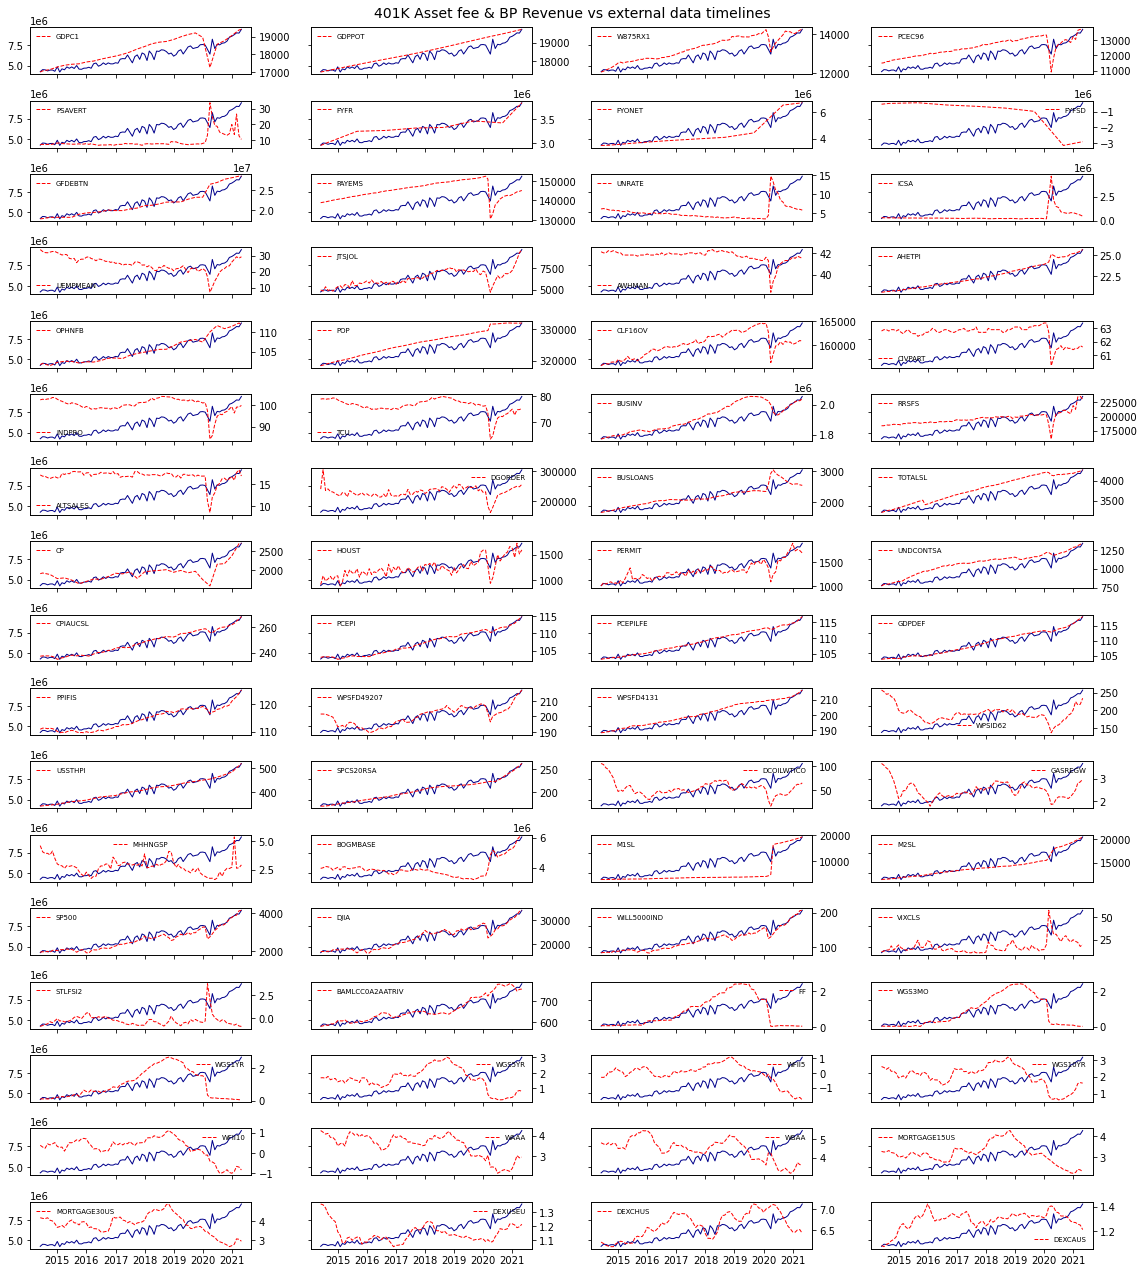

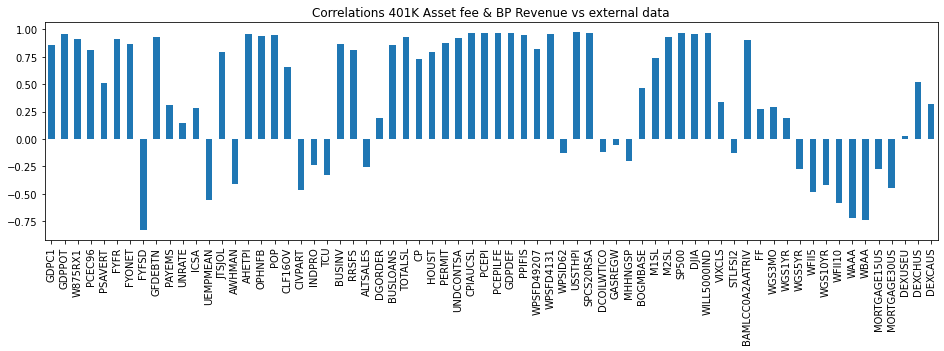

In [238]:
item = '401K Asset fee & BP Revenue'
c0 = correlation_analysis(item, df_items, df_ext.droplevel(0, axis=1))

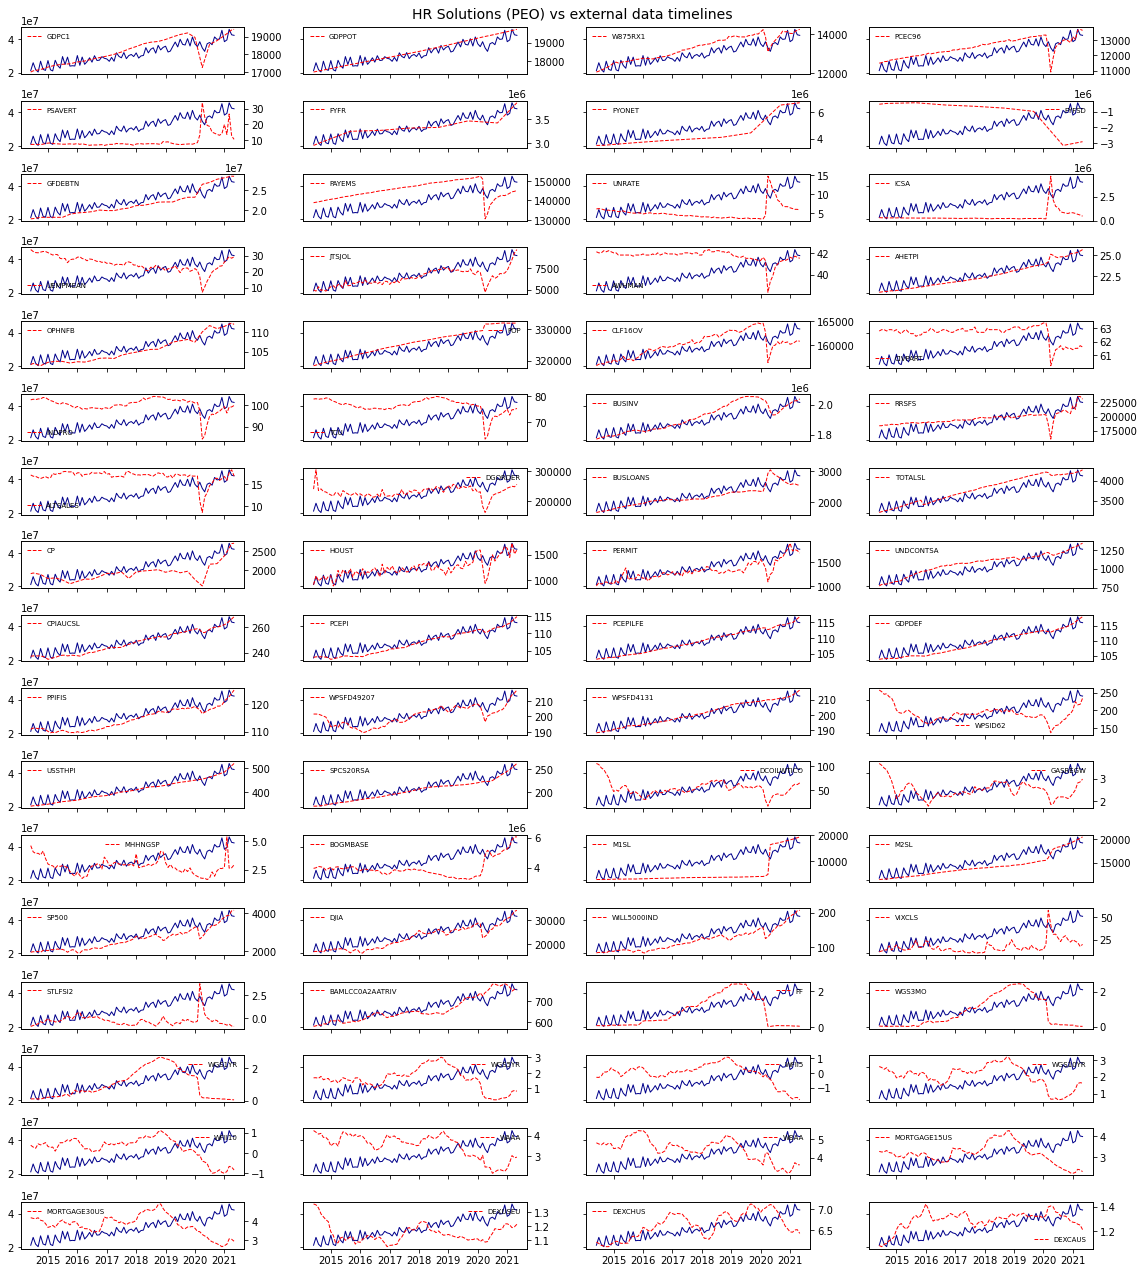

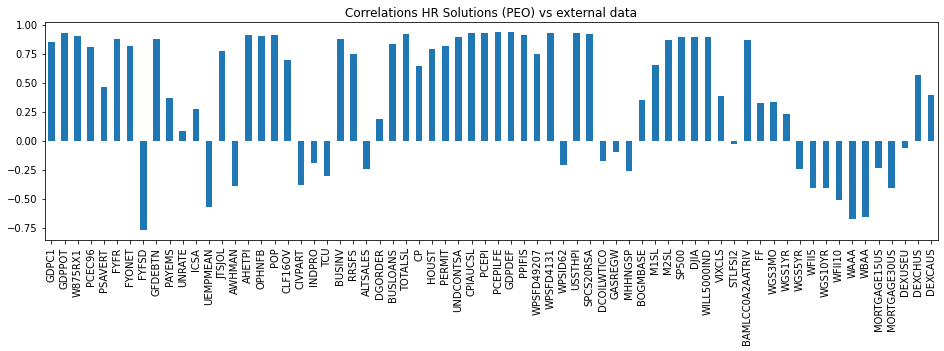

In [124]:
item = 'HR Solutions (PEO)'
c0 = correlation_analysis(item, df_items, df_ext, lag=0)

In [130]:
list_correlations = []
for item in items:
    print('Analysis for item {}.'.format(item))
    c = correlation_analysis(item, df_items, df_ext, plot=False)
    list_correlations.append(c)

Analysis for item 401K Asset fee & BP Revenue.
Analysis for item 401K Fee Revenue.
Analysis for item ASO Allocation.
Analysis for item ASO Revenue - Oasis.
Analysis for item Benetrac.
Analysis for item Cafeteria Plans Revenue.
Analysis for item Delivery Revenue.
Analysis for item Emerging Products.
Analysis for item ESR Revenue.
Analysis for item Full Service Unemployment Revenue.
Analysis for item Health Benefits.
Analysis for item HR Online.
Analysis for item HR Solutions (PEO).
Analysis for item Interest on Funds Held for Clients.
Analysis for item Other Processing Revenue.
Analysis for item Payroll blended products.
Analysis for item SurePayroll..
Analysis for item Time & Attendance.
Analysis for item Total international.
Analysis for item Total Paychex Advance.
Analysis for item Total PEO.
Analysis for item W-2 Revenue.
Analysis for item Workers Comp - Payment Services.


In [132]:
df_cor = pd.concat(list_correlations, axis=1)

In [137]:
df_cor

,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,Emerging Products,ESR Revenue,Full Service Unemployment Revenue,...,Interest on Funds Held for Clients,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total international,Total Paychex Advance,Total PEO,W-2 Revenue,Workers Comp - Payment Services
GDPC1,0.9,0.7,0.8,0.6,-0.6,0.0,0.0,0.7,0.4,0.8,...,0.6,0.3,0.1,0.7,0.9,-0.0,0.8,0.8,0.0,0.4
GDPPOT,1.0,0.8,0.9,0.7,-0.7,-0.1,-0.0,0.8,0.4,0.8,...,0.6,0.2,-0.1,0.8,1.0,-0.0,0.8,0.9,0.0,0.3
W875RX1,0.9,0.8,0.9,0.7,-0.7,0.1,0.0,0.7,0.5,0.8,...,0.6,0.3,0.0,0.8,1.0,-0.0,0.8,0.9,0.0,0.4
PCEC96,0.8,0.6,0.8,0.5,-0.6,0.1,0.0,0.6,0.4,0.7,...,0.5,0.3,0.1,0.7,0.8,-0.0,0.8,0.8,0.1,0.4
PSAVERT,0.5,0.4,0.5,0.4,-0.3,-0.2,-0.0,0.6,0.1,0.3,...,0.3,0.1,-0.3,0.4,0.4,-0.0,0.3,0.5,-0.0,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORTGAGE15US,-0.3,-0.2,-0.3,-0.2,0.2,0.3,0.0,-0.6,0.0,-0.1,...,0.3,0.0,0.2,-0.2,-0.2,0.0,-0.0,-0.2,-0.0,0.3
MORTGAGE30US,-0.4,-0.3,-0.4,-0.3,0.3,0.3,0.0,-0.7,-0.1,-0.3,...,0.1,-0.0,0.2,-0.4,-0.4,-0.0,-0.2,-0.4,-0.0,0.3
DEXUSEU,0.0,0.0,-0.0,-0.2,-0.0,-0.0,-0.0,0.1,-0.2,-0.2,...,-0.2,-0.0,-0.1,-0.0,-0.1,0.0,-0.2,-0.1,0.0,-0.1
DEXCHUS,0.5,0.4,0.5,0.6,-0.5,0.1,-0.0,0.3,0.3,0.6,...,0.6,0.1,0.1,0.5,0.7,-0.1,0.7,0.6,-0.1,0.3


<AxesSubplot:>

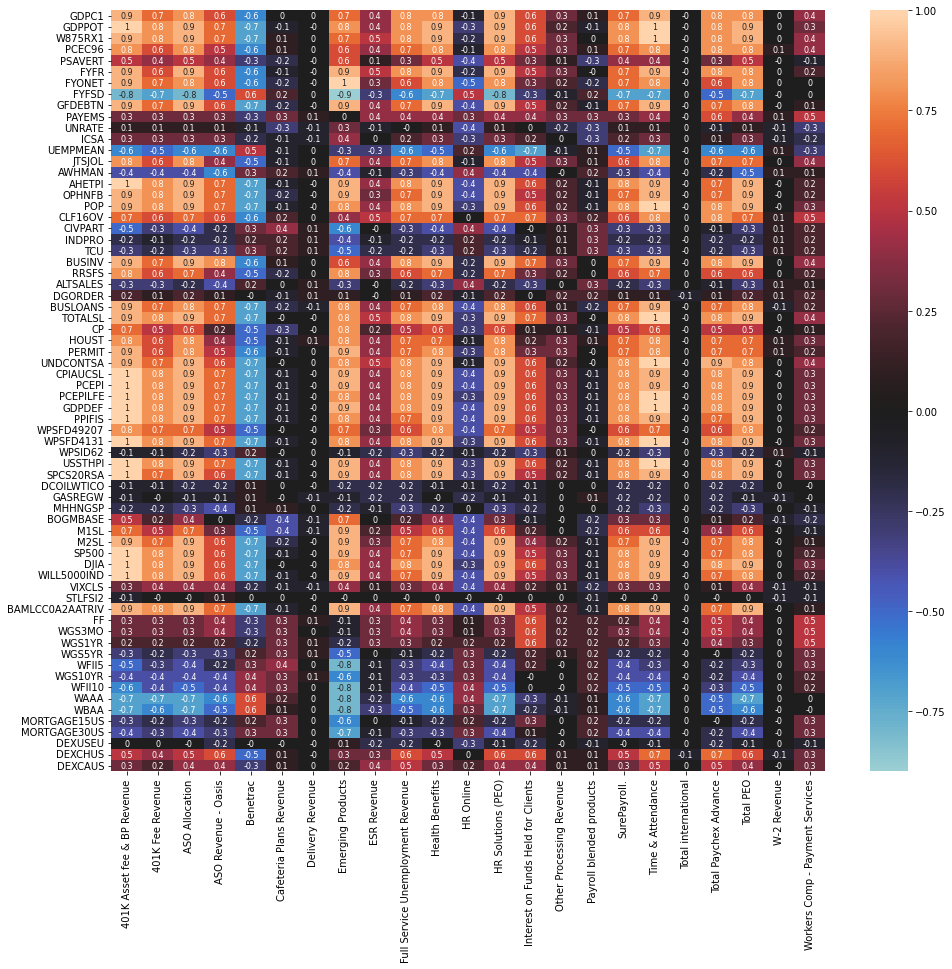

In [142]:
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(df_cor.round(1), annot=True, center=0, annot_kws={"size":8}, ax=ax)

## External data selecction

In [148]:
corr_ext = df_ext.droplevel(0, axis=1).corr()

<AxesSubplot:>

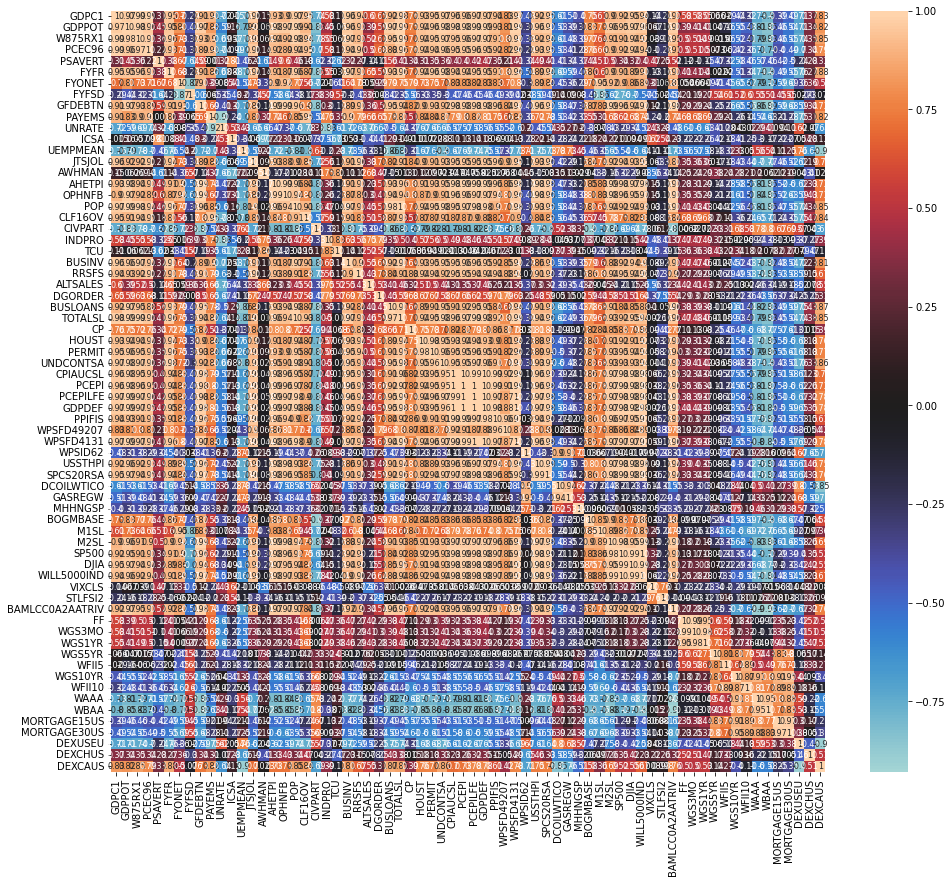

In [149]:
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(corr_ext, annot=True, center=0, annot_kws={"size":8}, ax=ax)

In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [187]:
X = df_ext[(df_ext.index>='20140601')&(df_ext.index<='20210501')].droplevel(0, axis=1)

In [188]:
X

,GDPC1,GDPPOT,W875RX1,PCEC96,PSAVERT,FYFR,FYONET,FYFSD,GFDEBTN,PAYEMS,...,WFII5,WGS10YR,WFII10,WAAA,WBAA,MORTGAGE15US,MORTGAGE30US,DEXUSEU,DEXCHUS,DEXCAUS
date,,,,,,,,,,,,,,,,,,,,,
20140601,16999.833473,17399.562328,12042.7,11489.7,7.1,2.959388e+06,3.493328e+06,-5.339391e+05,1.776095e+07,138837.0,...,-0.2875,2.6025,0.3750,4.2550,4.8025,3.2650,4.1625,1.359486,6.230605,1.083038
20140701,17064.616000,17426.090880,12085.3,11512.3,7.2,2.979639e+06,3.497553e+06,-5.179132e+05,1.782407e+07,139069.0,...,-0.2925,2.5475,0.2875,4.1750,4.7400,3.2360,4.1300,1.353336,6.198436,1.073918
20140801,17090.433272,17453.411426,12150.7,11590.9,7.0,3.000565e+06,3.501918e+06,-5.013531e+05,1.793101e+07,139257.0,...,-0.2100,2.4380,0.2280,4.0820,4.6940,3.2475,4.1150,1.331524,6.154129,1.092633
20140901,17116.250543,17480.731972,12196.7,11593.8,7.2,3.021491e+06,3.506284e+06,-4.847930e+05,1.803795e+07,139566.0,...,0.0800,2.5350,0.4450,4.1175,4.7975,3.3075,4.1625,1.288910,6.138229,1.101052
20141001,17141.235000,17507.171210,12257.0,11665.2,7.1,3.040264e+06,3.521536e+06,-4.812725e+05,1.814144e+07,139818.0,...,0.0720,2.3180,0.3940,3.9200,4.6920,3.2100,4.0360,1.267732,6.125050,1.121155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,19055.655000,19602.540000,14031.9,13201.3,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,2.813257e+07,143017.0,...,-1.6380,1.0540,-1.0100,2.4080,3.2240,2.2000,2.7350,1.217767,6.467178,1.272461
20210201,19163.347278,19635.200222,14028.9,13025.4,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,2.826927e+07,143727.0,...,-1.7675,1.2625,-0.9225,2.7025,3.4200,2.2375,2.8100,1.209395,6.460058,1.269647
20210301,19260.617722,19664.699778,14124.2,13621.3,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,2.839274e+07,144431.0,...,-1.6800,1.5925,-0.6700,3.0325,3.7375,2.3925,3.0825,1.190161,6.510861,1.256896


In [260]:
def multi_selection(X, n_drop = 3):

    X_sel=X.copy()
    X_sel['intercept'] = 1

    if n_drop == 'all':
        x_vif=100
        while x_vif >10:

            vif = pd.DataFrame()
            vif["Variable"] = X_sel.columns
            vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
            vif = vif[(vif['Variable']!='intercept')&(~np.isinf(vif['VIF']))].sort_values('VIF', ascending=False)
            x_del = vif.iloc[0,0]
            x_vif = vif.iloc[0,1]
            X_sel = X_sel.drop(x_del, axis=1)
            print("Droped column: {} \t vif: {}".format(x_del, x_vif))

    else:
        for n in range(n_drop):
            vif = pd.DataFrame()
            vif["Variable"] = X_sel.columns
            vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
            vif = vif[(vif['Variable']!='intercept')&(~np.isinf(vif['VIF']))].sort_values('VIF', ascending=False)
            x_del = vif.iloc[0,0]
            X_sel = X_sel.drop(x_del, axis=1)
            print("Droped column: {} \t vif: {}".format(x_del, vif.iloc[0,1]))

    X_sel = X_sel.drop('intercept', axis=1)
    return X_sel

In [242]:
X_sel = multi_selection(X, n_drop=48)

c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: GDPPOT 	 vif: 205890.68967051964
Droped column: PCEPI 	 vif: 86019.07234142236


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: M2SL 	 vif: 79944.71769646679
Droped column: SP500 	 vif: 67525.00626940589


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: SPCS20RSA 	 vif: 59226.6497566616
Droped column: TCU 	 vif: 27945.647813481406


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: POP 	 vif: 18765.95833310485
Droped column: AHETPI 	 vif: 17283.401694753164


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEPILFE 	 vif: 15353.072363851456
Droped column: GDPDEF 	 vif: 11069.081345232471


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: USSTHPI 	 vif: 10323.199624485987
Droped column: CPIAUCSL 	 vif: 8068.331057576667


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WPSFD4131 	 vif: 5448.739418238942
Droped column: BAMLCC0A2AATRIV 	 vif: 5138.449160420611


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WGS5YR 	 vif: 3657.8676974940277
Droped column: GFDEBTN 	 vif: 3355.1395644073605


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEC96 	 vif: 3285.727511064036
Droped column: MORTGAGE30US 	 vif: 2450.3171478407803
Droped column: WGS3MO 	 vif: 2233.587605746125


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WILL5000IND 	 vif: 2093.052383227851
Droped column: PAYEMS 	 vif: 1744.4510112298221
Droped column: PPIFIS 	 vif: 1300.928337761373


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: BUSLOANS 	 vif: 1105.7052330836596
Droped column: UNDCONTSA 	 vif: 936.794911364836
Droped column: BUSINV 	 vif: 746.4901552643834


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: TOTALSL 	 vif: 682.3678774432451
Droped column: CLF16OV 	 vif: 608.6304393985179
Droped column: WFII10 	 vif: 528.3616409266547
Droped column: OPHNFB 	 vif: 497.68835491600447


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: W875RX1 	 vif: 411.0017279996988
Droped column: DJIA 	 vif: 399.0734157989279
Droped column: WGS10YR 	 vif: 383.1343994745231
Droped column: M1SL 	 vif: 273.2252830237664
Droped column: WAAA 	 vif: 234.3983417938069
Droped column: WGS1YR 	 vif: 225.75353973307963
Droped column: WPSFD49207 	 vif: 143.26877303466281


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

Droped column: GDPC1 	 vif: 123.52004717112382
Droped column: WFII5 	 vif: 103.29484743748863
Droped column: BOGMBASE 	 vif: 69.92728217845952
Droped column: ICSA 	 vif: 61.95647198488413
Droped column: UNRATE 	 vif: 61.47582535969381
Droped column: WPSID62 	 vif: 42.760034156838046
Droped column: RRSFS 	 vif: 29.025329312384407
Droped column: JTSJOL 	 vif: 27.752579386129437
Droped column: DCOILWTICO 	 vif: 25.087701773715782
Droped column: FF 	 vif: 23.220954666459388
Droped column: UEMPMEAN 	 vif: 19.949045674239496
Droped column: AWHMAN 	 vif: 16.562241426294687


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [243]:
X_sel

,PSAVERT,FYFR,FYONET,FYFSD,CIVPART,INDPRO,ALTSALES,DGORDER,CP,HOUST,PERMIT,GASREGW,MHHNGSP,VIXCLS,STLFSI2,WBAA,MORTGAGE15US,DEXUSEU,DEXCHUS,DEXCAUS
date,,,,,,,,,,,,,,,,,,,,
20140601,7.1,2.959388e+06,3.493328e+06,-5.339391e+05,62.8,102.5722,17.125,239998.0,1900.418780,911.0,1010.0,3.69160,4.59,11.541429,-0.884450,4.8025,3.2650,1.359486,6.230605,1.083038
20140701,7.2,2.979639e+06,3.497553e+06,-5.179132e+05,62.9,102.8479,16.851,304221.0,1917.769000,1085.0,1076.0,3.61125,4.05,12.296364,-0.789300,4.7400,3.2360,1.353336,6.198436,1.073918
20140801,7.0,3.000565e+06,3.501918e+06,-5.013531e+05,62.9,102.6491,16.808,235113.0,1904.742261,984.0,1047.0,3.48650,3.91,13.491905,-0.699140,4.6940,3.2475,1.331524,6.154129,1.092633
20140901,7.2,3.021491e+06,3.506284e+06,-4.847930e+05,62.8,102.9858,16.527,240539.0,1891.715522,1023.0,1077.0,3.40620,3.92,13.466667,-0.599750,4.7975,3.3075,1.288910,6.138229,1.101052
20141001,7.1,3.040264e+06,3.521536e+06,-4.812725e+05,62.9,102.9911,16.326,231947.0,1879.109000,1074.0,1094.0,3.17050,3.78,18.058696,-0.365240,4.6920,3.2100,1.267732,6.125050,1.121155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,61.4,99.4076,16.779,243160.0,2367.593000,1625.0,1883.0,2.33425,2.71,24.910000,-0.634300,3.2240,2.2000,1.217767,6.467178,1.272461
20210201,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,61.5,96.3966,15.932,246261.0,2478.777944,1447.0,1726.0,2.50100,5.35,23.140526,-0.744350,3.4200,2.2375,1.209395,6.460058,1.269647
20210301,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,61.5,99.1618,17.641,249467.0,2579.203056,1725.0,1755.0,2.81040,2.62,21.843043,-0.631475,3.7375,2.3925,1.190161,6.510861,1.256896


<AxesSubplot:>

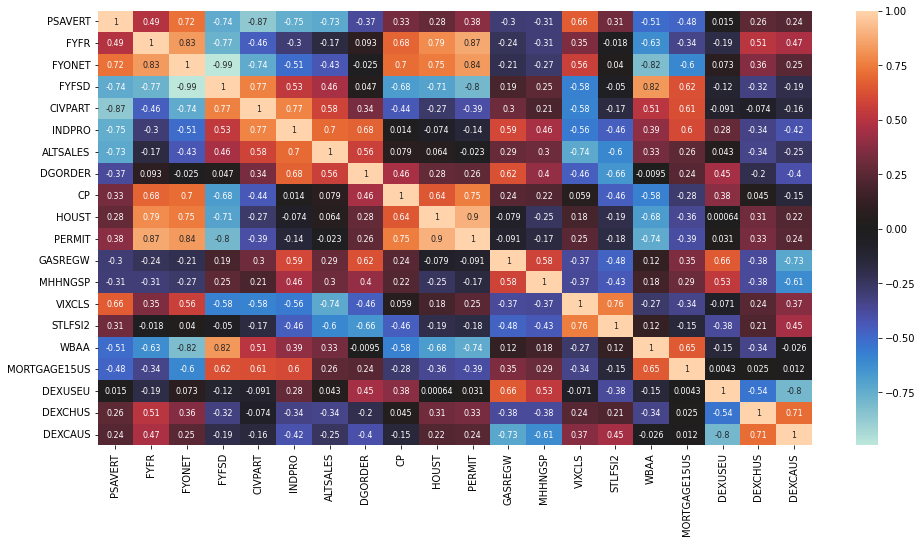

In [245]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(X_sel.corr(), annot=True, center=0, annot_kws={"size":8}, ax=ax)

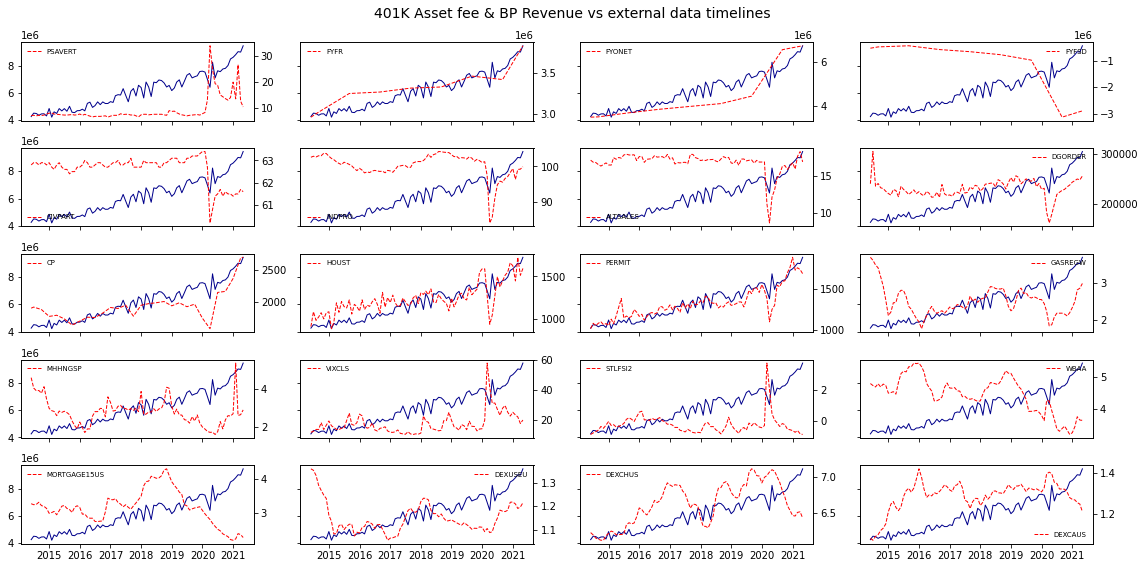

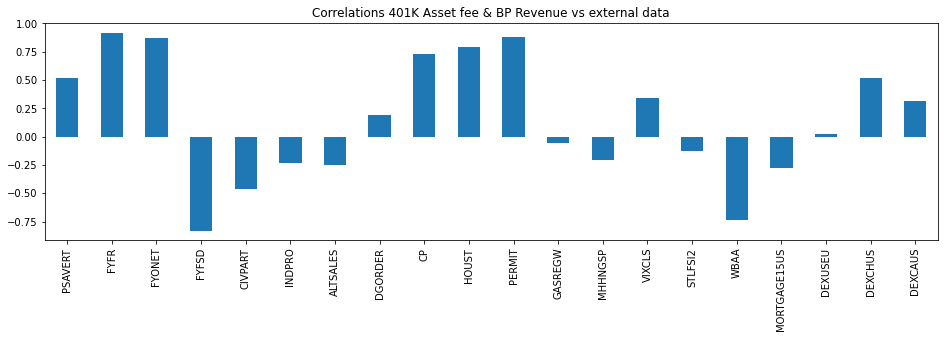

In [248]:
item = '401K Asset fee & BP Revenue'
c0 = correlation_analysis(item, df_items, X_sel, figsize=(16,8))

In [256]:
list_correlations2 = []
for item in items:
    print('Analysis for item {}.'.format(item))
    c = correlation_analysis(item, df_items, X_sel, plot=False)
    list_correlations2.append(c)

Analysis for item 401K Asset fee & BP Revenue.
Analysis for item 401K Fee Revenue.
Analysis for item ASO Allocation.
Analysis for item ASO Revenue - Oasis.
Analysis for item Benetrac.
Analysis for item Cafeteria Plans Revenue.
Analysis for item Delivery Revenue.
Analysis for item Emerging Products.
Analysis for item ESR Revenue.
Analysis for item Full Service Unemployment Revenue.
Analysis for item Health Benefits.
Analysis for item HR Online.
Analysis for item HR Solutions (PEO).
Analysis for item Interest on Funds Held for Clients.
Analysis for item Other Processing Revenue.
Analysis for item Payroll blended products.
Analysis for item SurePayroll..
Analysis for item Time & Attendance.
Analysis for item Total international.
Analysis for item Total Paychex Advance.
Analysis for item Total PEO.
Analysis for item W-2 Revenue.
Analysis for item Workers Comp - Payment Services.


In [258]:
df_cor2 = pd.concat(list_correlations2, axis=1)

<AxesSubplot:>

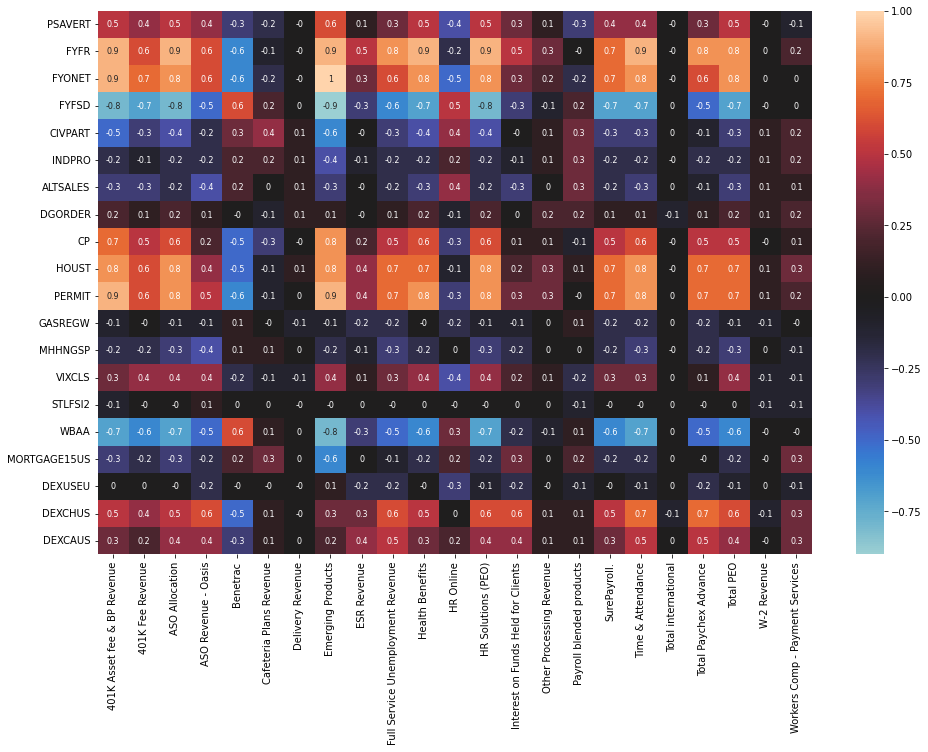

In [263]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_cor2.round(1), annot=True, center=0, annot_kws={"size":8}, ax=ax)

In [266]:
X_sel.reset_index().to_feather("ext_var_sel.feather")

### Selectin with threshold

In [261]:
X_sel2 = multi_selection(X, n_drop='all')

c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: GDPPOT 	 vif: 205890.68967051964
Droped column: PCEPI 	 vif: 86019.07234142236


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: M2SL 	 vif: 79944.71769646679
Droped column: SP500 	 vif: 67525.00626940589


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: SPCS20RSA 	 vif: 59226.6497566616
Droped column: TCU 	 vif: 27945.647813481406


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: POP 	 vif: 18765.95833310485
Droped column: AHETPI 	 vif: 17283.401694753164


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEPILFE 	 vif: 15353.072363851456
Droped column: GDPDEF 	 vif: 11069.081345232471


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: USSTHPI 	 vif: 10323.199624485987
Droped column: CPIAUCSL 	 vif: 8068.331057576667


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WPSFD4131 	 vif: 5448.739418238942
Droped column: BAMLCC0A2AATRIV 	 vif: 5138.449160420611


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WGS5YR 	 vif: 3657.8676974940277
Droped column: GFDEBTN 	 vif: 3355.1395644073605


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEC96 	 vif: 3285.727511064036
Droped column: MORTGAGE30US 	 vif: 2450.3171478407803
Droped column: WGS3MO 	 vif: 2233.587605746125


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WILL5000IND 	 vif: 2093.052383227851
Droped column: PAYEMS 	 vif: 1744.4510112298221
Droped column: PPIFIS 	 vif: 1300.928337761373


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: BUSLOANS 	 vif: 1105.7052330836596
Droped column: UNDCONTSA 	 vif: 936.794911364836
Droped column: BUSINV 	 vif: 746.4901552643834
Droped column: TOTALSL 	 vif: 682.3678774432451


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: CLF16OV 	 vif: 608.6304393985179
Droped column: WFII10 	 vif: 528.3616409266547
Droped column: OPHNFB 	 vif: 497.68835491600447
Droped column: W875RX1 	 vif: 411.0017279996988
Droped column: DJIA 	 vif: 399.0734157989279
Droped column: WGS10YR 	 vif: 383.1343994745231


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

Droped column: M1SL 	 vif: 273.2252830237664
Droped column: WAAA 	 vif: 234.3983417938069
Droped column: WGS1YR 	 vif: 225.75353973307963
Droped column: WPSFD49207 	 vif: 143.26877303466281
Droped column: GDPC1 	 vif: 123.52004717112382
Droped column: WFII5 	 vif: 103.29484743748863
Droped column: BOGMBASE 	 vif: 69.92728217845952
Droped column: ICSA 	 vif: 61.95647198488413
Droped column: UNRATE 	 vif: 61.47582535969381
Droped column: WPSID62 	 vif: 42.760034156838046


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

Droped column: RRSFS 	 vif: 29.025329312384407
Droped column: JTSJOL 	 vif: 27.752579386129437
Droped column: DCOILWTICO 	 vif: 25.087701773715782
Droped column: FF 	 vif: 23.220954666459388
Droped column: UEMPMEAN 	 vif: 19.949045674239496
Droped column: AWHMAN 	 vif: 16.562241426294687
Droped column: VIXCLS 	 vif: 15.855031968443674
Droped column: DEXCAUS 	 vif: 14.594650970512745
Droped column: PERMIT 	 vif: 14.055028980330494
Droped column: CIVPART 	 vif: 12.410569500435251
Droped column: WBAA 	 vif: 8.163164747575282


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

In [262]:
X_sel2

,PSAVERT,FYFR,FYONET,FYFSD,INDPRO,ALTSALES,DGORDER,CP,HOUST,GASREGW,MHHNGSP,STLFSI2,MORTGAGE15US,DEXUSEU,DEXCHUS
date,,,,,,,,,,,,,,,
20140601,7.1,2.959388e+06,3.493328e+06,-5.339391e+05,102.5722,17.125,239998.0,1900.418780,911.0,3.69160,4.59,-0.884450,3.2650,1.359486,6.230605
20140701,7.2,2.979639e+06,3.497553e+06,-5.179132e+05,102.8479,16.851,304221.0,1917.769000,1085.0,3.61125,4.05,-0.789300,3.2360,1.353336,6.198436
20140801,7.0,3.000565e+06,3.501918e+06,-5.013531e+05,102.6491,16.808,235113.0,1904.742261,984.0,3.48650,3.91,-0.699140,3.2475,1.331524,6.154129
20140901,7.2,3.021491e+06,3.506284e+06,-4.847930e+05,102.9858,16.527,240539.0,1891.715522,1023.0,3.40620,3.92,-0.599750,3.3075,1.288910,6.138229
20141001,7.1,3.040264e+06,3.521536e+06,-4.812725e+05,102.9911,16.326,231947.0,1879.109000,1074.0,3.17050,3.78,-0.365240,3.2100,1.267732,6.125050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,99.4076,16.779,243160.0,2367.593000,1625.0,2.33425,2.71,-0.634300,2.2000,1.217767,6.467178
20210201,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,96.3966,15.932,246261.0,2478.777944,1447.0,2.50100,5.35,-0.744350,2.2375,1.209395,6.460058
20210301,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,99.1618,17.641,249467.0,2579.203056,1725.0,2.81040,2.62,-0.631475,2.3925,1.190161,6.510861


## Correlations over time

In [251]:
def correlation_lag(df_item, df_ext, item, ext, lag=12, plot=True):

    s_item = df_item[item]
    s_ext = df_ext[ext]

    list_series = [s_item]
    for l in range(lag+1):
        list_series.append(s_ext.shift(l).rename(ext+'_lag{}'.format(l)))

    df_cor = pd.concat(list_series, axis=1, join='inner').corr()[item][1:]

    if plot:
        fig, ax = plt.subplots(figsize=(10,3))
        df_cor.plot\
            .bar(title="Correlation over time {} vs {} (obs. {})".format(item, ext, list_series[1].shape[0]),
                 rot=90,
                 ax=ax)
    return df_cor

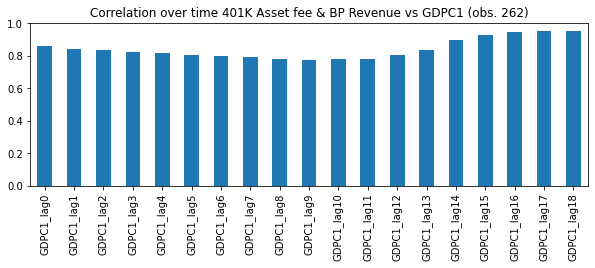

In [252]:
df_cor_lag = correlation_lag(df_items, df_ext.droplevel(0, axis=1), item, 'GDPC1', lag=18)

In [253]:
df_ext

Nation Income & Expenditures                                          \
                                GDPC1        GDPPOT  W875RX1   PCEC96 PSAVERT   
date                                                                            
20100101                 15456.059000  16173.804340  10490.7  10547.0     5.9   
20100201                 15507.577211  16192.208007  10487.0  10586.5     5.6   
20100301                 15554.109789  16208.830673  10529.1  10637.1     5.6   
20100401                 15605.628000  16227.234340  10638.7  10658.8     6.2   
20100501                 15645.404044  16245.702080  10740.6  10685.3     6.7   
...                               ...           ...      ...      ...     ...   
20310601                          NaN  23688.814835      NaN      NaN     NaN   
20310701                          NaN  23721.650000      NaN      NaN     NaN   
20310801                          NaN  23755.231087      NaN      NaN     NaN   
20310901                          NaN  23788.812174      NaN      NaN     NaN   
20311001                          NaN  23821.310000      NaN      NaN     NaN   

                                                                  \
                  FYFR        FYONET         FYFSD       GFDEBTN   
date                                                               
20100101  2.124281e+06  3.497422e+06 -1.373142e+06  1.277312e+07   
20100201  2.129183e+06  3.492276e+06 -1.363093e+06  1.292078e+07   
20100301  2.133610e+06  3.487627e+06 -1.354017e+06  1.305414e+07   
20100401  2.138512e+06  3.482480e+06 -1.343968e+06  1.320179e+07   
20100501  2.143256e+06  3.477500e+06 -1.334244e+06  1.332042e+07   
...                ...           ...           ...           ...   
20310601           NaN           NaN           NaN           NaN   
20310701           NaN           NaN           NaN           NaN   
20310801           NaN           NaN           NaN           NaN   
20310901           NaN           NaN           NaN           NaN   
20311001           NaN           NaN           NaN           NaN   

         Pop Employment Labor  ... Money Bank Finance                          \
                       PAYEMS  ...              WFII5 WGS10YR  WFII10    WAAA   
date                           ...                                              
20100101             129790.0  ...             0.4380   3.750  1.3940  5.2760   
20100201             129698.0  ...             0.4175   3.695  1.4225  5.3500   
20100301             129879.0  ...             0.5325   3.705  1.4900  5.2575   
20100401             130110.0  ...             0.6360   3.850  1.5160  5.2940   
20100501             130650.0  ...             0.4100   3.420  1.3075  4.9625   
...                       ...  ...                ...     ...     ...     ...   
20310601                  NaN  ...                NaN     NaN     NaN     NaN   
20310701                  NaN  ...                NaN     NaN     NaN     NaN   
20310801                  NaN  ...                NaN     NaN     NaN     NaN   
20310901                  NaN  ...                NaN     NaN     NaN     NaN   
20311001                  NaN  ...                NaN     NaN     NaN     NaN   

                                                                          
            WBAA MORTGAGE15US MORTGAGE30US   DEXUSEU   DEXCHUS   DEXCAUS  
date                                                                      
20100101  6.2780       4.4350       5.0300  1.426574  6.826916  1.043811  
20100201  6.3475       4.3675       4.9900  1.367995  6.828463  1.057211  
20100301  6.2625       4.3300       4.9675  1.357004  6.826183  1.022900  
20100401  6.2660       4.4180       5.0980  1.341682  6.825550  1.005209  
20100501  6.0500       4.2775       4.8875  1.256315  6.827450  1.040280  
...          ...          ...          ...       ...       ...       ...  
20310601     NaN          NaN          NaN       NaN       NaN       NaN  
20310701     NaN          NaN       

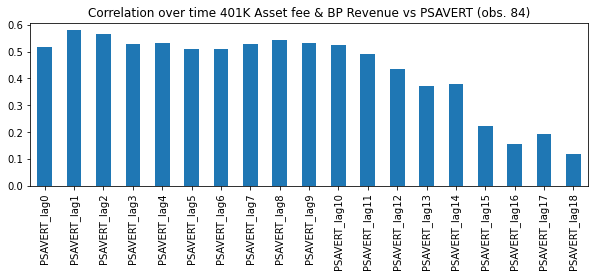

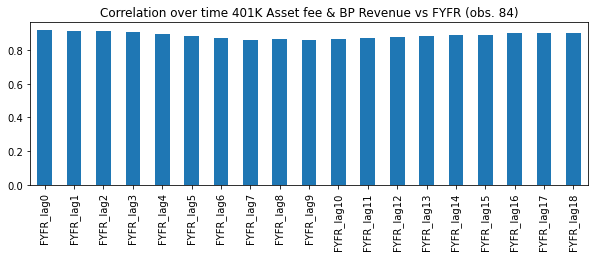

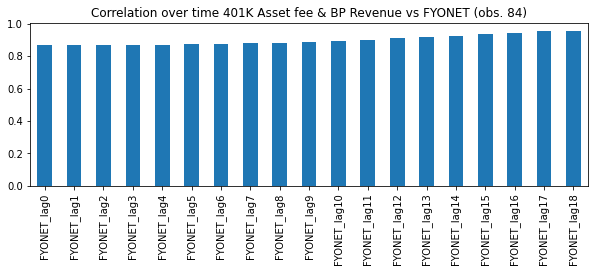

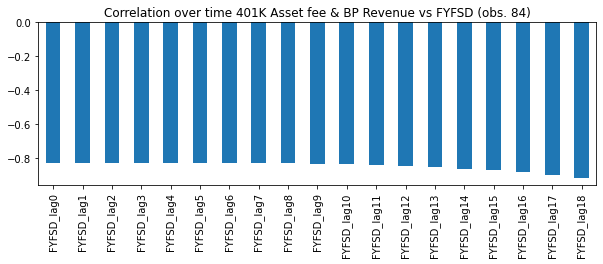

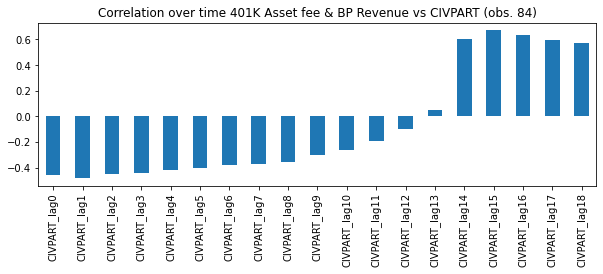

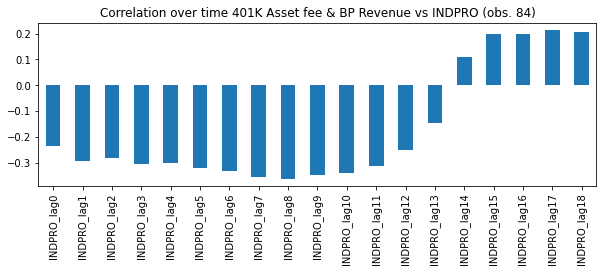

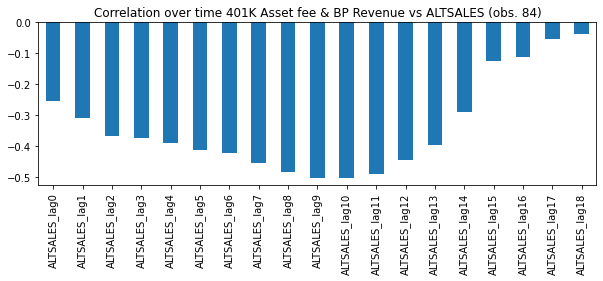

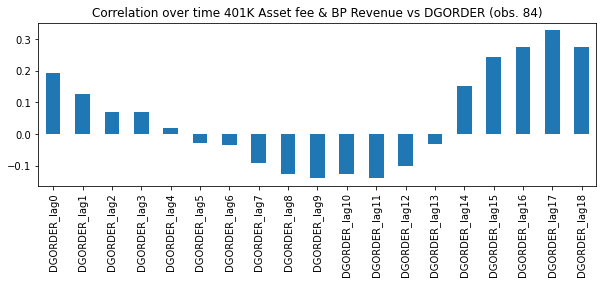

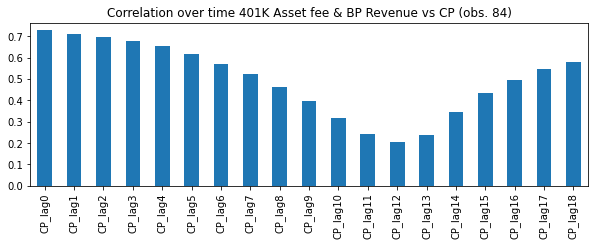

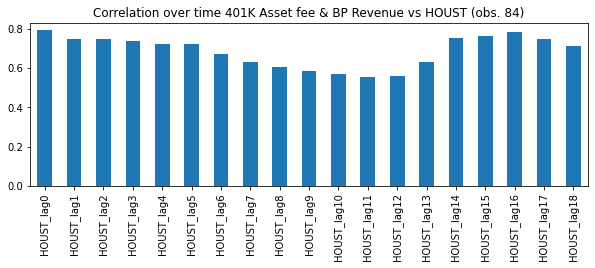

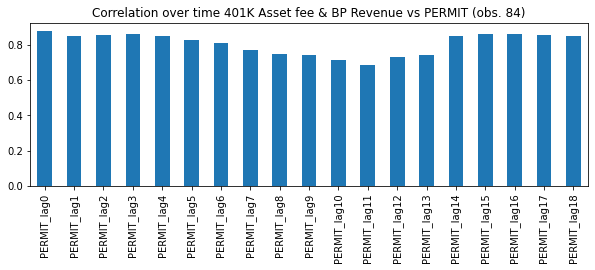

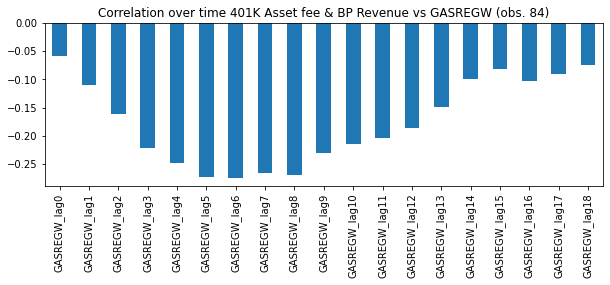

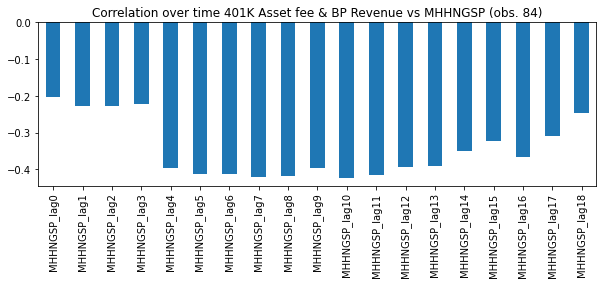

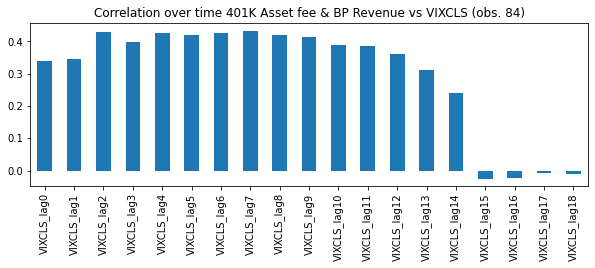

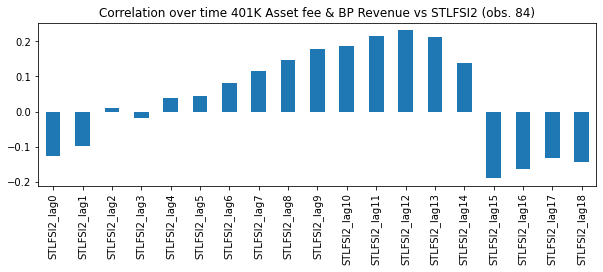

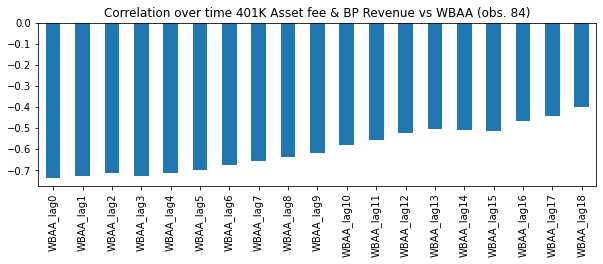

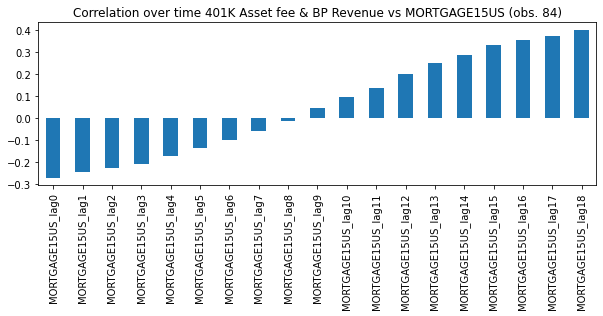

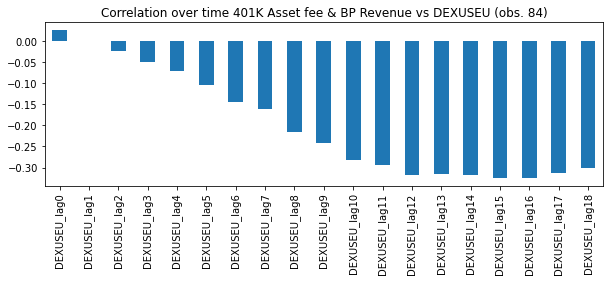

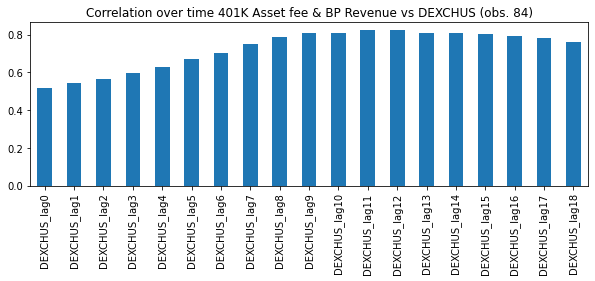

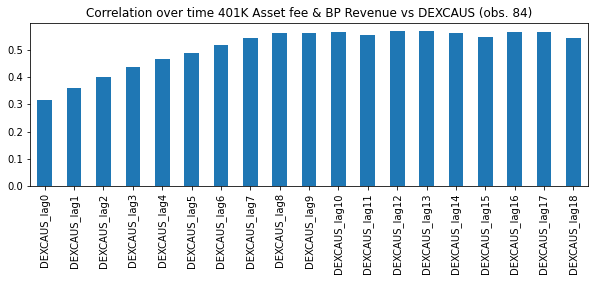

In [255]:
item = '401K Asset fee & BP Revenue'
for e in X_sel.columns:
    df_cor_lag = correlation_lag(df_items, X_sel, item, e, lag=18)